# Message 3

In [119]:
import math
import string
import nltk
nltk.download('words')
from nltk.corpus import words as english_words
from collections import Counter
import matplotlib.pyplot as plt

ciphertext = "osasangnftrunsnahtfiwettarawctteeilthomyeonsbasgriiueorw"

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Initial Frequency Analysis

* Initial comment - message is very short therefore frequency analysis results may not mirror those of the English Language accurately

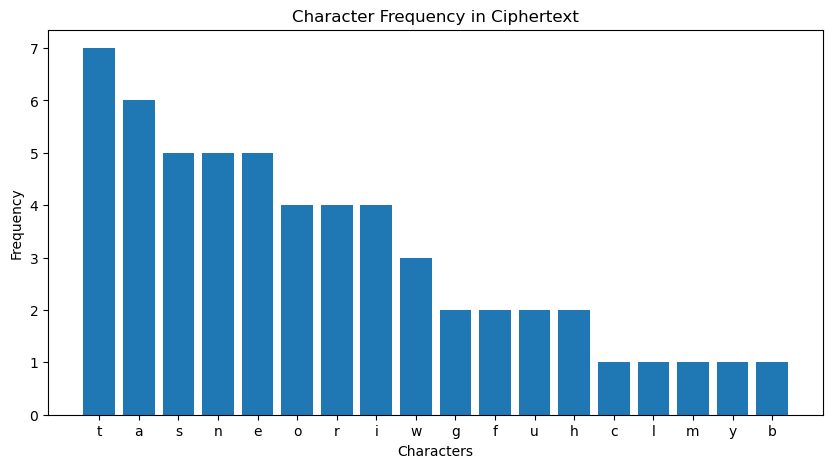

In [120]:
## frequency analysis

# strip text, count frequencies, sort by frequency
frequency = Counter(ciphertext)
sorted_frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))

# Plot the frequencies
plt.figure(figsize=(10, 5))
plt.bar(sorted_frequency.keys(), sorted_frequency.values())
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency in Ciphertext')
plt.show()

* Distribution matches that of the English Language but is slightly flat - most likely due to message length
* Specific letters do not match English language perfectly HOWEVER there is a resemblence to English language
* We can use Kandall Tau Distance and Spearman's Rank Correlation to measure the similarity of the frequency ordering of this text vs the English langauge

In [121]:
# Kendall's tau and Spearman's rank correlation coefficient
from scipy.stats import kendalltau, spearmanr

# compare to message 1 which was polialphabetic substitution
message1 = """Oirmf qjff nfrh ub wf n bsbrjab bjvsriffn bzjotnu gzbpcfen ja oir ndujpyn uuztr ybln dbidrmory
xvoi opjyyjab dudmqmfa nfya ffofrh. Srrbeyjab uuz dudmqmfa ape nibrjab qnojridr voq  fjayornt, sjs ydtgzovih nouriuvqfyt, bay gbm
jzksbqjab uuzje xpzhvaddnojbit ffjygt, vn crdot ptry ja hbat tpcpbgt, zjtg ztczdvvmyt qez-tpcpbgt"""

# strip text, count frequencies, sort by frequency
message1_cleaned = ''.join(filter(str.isalpha, message1)).lower()
m1_frequency = Counter(message1_cleaned)
m1_sorted_frequency = dict(sorted(m1_frequency.items(), key=lambda item: item[1], reverse=True))


english_freq_order = "ETAOINSHRDLCUMWFGYPBVKXJQZ"[:18] # extracted from slides 
ciphertext_freq_order = ''.join(sorted_frequency.keys())
message1_freq_order = ''.join(m1_sorted_frequency.keys())

# Convert letters to ranks for comparison
english_ranks = {letter: rank for rank, letter in enumerate(english_freq_order.lower())}
ciphertext_ranks = [english_ranks[letter] for letter in ciphertext_freq_order if letter in english_ranks]
m1_ranks = [english_ranks[letter] for letter in message1_freq_order if letter in english_ranks]

# Generate the correct sequential ranking for comparison
expected_ranks = list(range(len(ciphertext_ranks)))
m1_expected_ranks = list(range(len(m1_ranks)))

# Compute Kendall Tau and Spearman's Rank Correlation
kendall_tau, _ = kendalltau(ciphertext_ranks, expected_ranks)
spearman_corr, _ = spearmanr(ciphertext_ranks, expected_ranks)

# Compute Kendall Tau and Spearman's Rank Correlation for message 1
m1_kendall_tau, _ = kendalltau(m1_ranks, m1_expected_ranks)
m1_spearman_corr, _ = spearmanr(m1_ranks, m1_expected_ranks)

print(f"Kendall Tau Distance: {kendall_tau}")
print(f"Spearman's Rank Correlation: {spearman_corr}")

print(f"Kendall Tau Distance for Message 1: {m1_kendall_tau}")
print(f"Spearman's Rank Correlation for Message 1: {m1_spearman_corr}")

Kendall Tau Distance: 0.5441176470588235
Spearman's Rank Correlation: 0.7549019607843138
Kendall Tau Distance for Message 1: 0.11111111111111112
Spearman's Rank Correlation for Message 1: 0.13519091847265222


* There is a clear similarity between the frequency order of English and the ciphertext
* When compared with the similarity for message 1 - which was substitution - there is a much greater similairty
* Suggesting that a transposition cipher has been used
* This can be further validated using IC. IC should ~= 0.68

In [122]:
# Index of Coincidence
def index_of_coincidence(text):
    N = len(text)
    frequency = Counter(text)
    return sum([frequency[letter] * (frequency[letter] - 1) for letter in frequency]) / (N * (N - 1))

print(f"Index of Coincidence: {index_of_coincidence(ciphertext)}")

Index of Coincidence: 0.05909090909090909


* Considering the length of the message, close enough to English
* A transposition cipher is used. The slides suggest that this could be a rail fence of columnar transposition cipher
* The rail fence is more simple therefore we will try that first

# Rail Fence Cipher

In [123]:
## helper functions

# define the rail pattern
def rail_pattern(n, key):
    if key == 1:
        return [0] * n
    period = 2 * (key - 1)
    pattern = []
    for i in range(n):
        r = i % period
        # r goes from 0 up to key-1, then back down
        pattern.append(r if r < key else period - r)
    return pattern

# print the rails for analysis
def pretty_print_rails(rails):
    key = len(rails)
    n = sum(len(rail) for rail in rails)  # Total number of characters
    
    # Generate the rail pattern
    pattern = rail_pattern(n, key)

    # Create an empty grid filled with underscores
    grid = [['_' for _ in range(n)] for _ in range(key)]

    # Place characters in the correct positions
    for col, row in enumerate(pattern):
        if rails[row]:
            grid[row][col] = rails[row].pop(0)  # Remove the first element from the rail

    # Print each row as a formatted string
    for row in grid:
        print(" ".join(row))

In [124]:
## rail cipher

n = len(ciphertext)
max_k = math.ceil(n / 2)
print("Message:", ciphertext)
for key in range(2, max_k+1):
    
    print("\nKey:",key)
    
    pattern = rail_pattern(n, key)
    # Count how many characters belong to each rail.
    rail_counts = [pattern.count(r) for r in range(key)]
    
    # Split the ciphertext into rails according to the counts.
    rails = []
    pos = 0
    for count in rail_counts:
        rails.append(list(ciphertext[pos:pos+count]))
        pos += count

    # Use a copy of rails so that pretty_print_rails doesn't modify the original rails.
    pretty_print_rails([r.copy() for r in rails])
    
    # Reconstruct the plaintext by reading the rails in zigzag order.
    plaintext_chars = []
    for r in pattern:
        plaintext_chars.append(rails[r].pop(0))
    
    plaintext = "".join(plaintext_chars)
    print("Message:",ciphertext)
    print("Plaintext:",plaintext)

Message: osasangnftrunsnahtfiwettarawctteeilthomyeonsbasgriiueorw

Key: 2
o _ s _ a _ s _ a _ n _ g _ n _ f _ t _ r _ u _ n _ s _ n _ a _ h _ t _ f _ i _ w _ e _ t _ t _ a _ r _ a _ w _
_ c _ t _ t _ e _ e _ i _ l _ t _ h _ o _ m _ y _ e _ o _ n _ s _ b _ a _ s _ g _ r _ i _ i _ u _ e _ o _ r _ w
Message: osasangnftrunsnahtfiwettarawctteeilthomyeonsbasgriiueorw
Plaintext: ocstatseaeniglntfhtormuynesonnashbtafsigwreitituaeroarww

Key: 3
o _ _ _ s _ _ _ a _ _ _ s _ _ _ a _ _ _ n _ _ _ g _ _ _ n _ _ _ f _ _ _ t _ _ _ r _ _ _ u _ _ _ n _ _ _ s _ _ _
_ n _ a _ h _ t _ f _ i _ w _ e _ t _ t _ a _ r _ a _ w _ c _ t _ t _ e _ e _ i _ l _ t _ h _ o _ m _ y _ e _ o
_ _ n _ _ _ s _ _ _ b _ _ _ a _ _ _ s _ _ _ g _ _ _ r _ _ _ i _ _ _ i _ _ _ u _ _ _ e _ _ _ o _ _ _ r _ _ _ w _
Message: osasangnftrunsnahtfiwettarawctteeilthomyeonsbasgriiueorw
Plaintext: onnashstafbiswaeatstnagrgarwncitftieteuirletuhoonmrysewo

Key: 4
o _ _ _ _ _ s _ _ _ _ _ a _ _ _ _ _ s _ _ _ _ _ a _ _ _ _ _ n _ _ _ _ _ g _ _ _ _ 

* No resulting text looks like English

## Columnar Transposition Cipher
* Message is written in rows of fixed length
* Key size should be a divisor of the ciphertext length

In [125]:
## coompute factors of message length

# message length
ciphertext_length = len(ciphertext)
print("Length:", ciphertext_length)

# potential key lengths with factors
factors = [1]
for i in range(2, ciphertext_length):
    if ciphertext_length % i == 0:
        factors.append(i)     
print("Factors:", factors)

Length: 56
Factors: [1, 2, 4, 7, 8, 14, 28]


* We can now arrange the ciphertext into tables with the number of columns equal to each factor

In [126]:
# Columnar Transposition cipher

# print columns to terminal
def pretty_print(columns, headless= False, idx=False, anagram=None):
    width = len(columns)
    height = len(columns[0])
    if headless == False:
        if anagram == None:
            print(str(width) + " columns:")
        else:
            print("Word:", anagram)
        
    for y in range(height):
        line = ""
        for x in range(width):
            line += columns[x][y] + " : " 
        line = line[:-2]
        if idx: 
            if y < 10:
                print(str(y)+" ","|", end=" ")
            else:
                print(str(y),"|", end=" ")
            
        print(line)

# generate column structure
def generate_columns(m, w, h):
    columns = [[] for _ in range(w)]
    for i in range(w):
        for j in range(h):
            columns[i].append(m[i*h+j]) 
    return columns

# arrange message into columns - skipping 1 (all lengths) and 2 (even lengths)
all_columns = {}
for no_columns in factors[2:]: 
    no_rows = math.ceil(ciphertext_length / no_columns)
    columns = generate_columns(ciphertext,no_columns, no_rows)
    all_columns[no_columns] = columns

    # print to console
    pretty_print(columns)
    print()

4 columns:
o : n : c : n 
s : a : t : s 
a : h : t : b 
s : t : e : a 
a : f : e : s 
n : i : i : g 
g : w : l : r 
n : e : t : i 
f : t : h : i 
t : t : o : u 
r : a : m : e 
u : r : y : o 
n : a : e : r 
s : w : o : w 

7 columns:
o : f : h : a : e : e : r 
s : t : t : r : i : o : i 
a : r : f : a : l : n : i 
s : u : i : w : t : s : u 
a : n : w : c : h : b : e 
n : s : e : t : o : a : o 
g : n : t : t : m : s : r 
n : a : t : e : y : g : w 

8 columns:
o : n : n : e : c : t : n : i 
s : f : a : t : t : h : s : i 
a : t : h : t : t : o : b : u 
s : r : t : a : e : m : a : e 
a : u : f : r : e : y : s : o 
n : n : i : a : i : e : g : r 
g : s : w : w : l : o : r : w 

14 columns:
o : a : f : n : h : w : a : c : e : h : e : b : r : e 
s : n : t : s : t : e : r : t : i : o : o : a : i : o 
a : g : r : n : f : t : a : t : l : m : n : s : i : r 
s : n : u : a : i : t : w : e : t : y : s : g : u : w 

28 columns:
o : a : a : g : f : r : n : n : h : f : w : t : a : a : c : t : e : l : h : 

* We can now look for anagrams in each table. Notable anagrams: 

* 4: your, safe, tout - your is very common
* 7: fear, hear
* 8: innocent - very long word, shift, about, same, your (again), grow(s)
* 8 has many words which even work together in context
* We can re-arrange the columns to make the words then check if the message appears

In [127]:
# "innocenet" - 8 columns
p = all_columns.get(8)
r = [7,1,2,0,4,3,6,5]
anagram = "innocent"
rearrangement = list(map(p.__getitem__, r))
pretty_print(rearrangement, anagram=anagram)
# only way to rearrange to make this word and no message appears

# shift - 8 columns
p = all_columns.get(8)
r = [6,5,7,1,3,4,0,2]
anagram = "shift"
rearrangement = list(map(p.__getitem__, r))
pretty_print(rearrangement, anagram=anagram)


Word: innocent
i : n : n : o : c : e : n : t 
i : f : a : s : t : t : s : h 
u : t : h : a : t : t : b : o 
e : r : t : s : e : a : a : m 
o : u : f : a : e : r : s : y 
r : n : i : n : i : a : g : e 
w : s : w : g : l : w : r : o 
Word: shift
n : t : i : n : e : c : o : n 
s : h : i : f : t : t : s : a 
b : o : u : t : t : t : a : h 
a : m : e : r : a : e : s : t 
s : y : o : u : r : e : a : f 
g : e : r : n : a : i : n : i 
r : o : w : s : w : l : g : w 


* Innocent - message not revealed and is the only way to rearrange the columns
* Shift - other anagrams from earlier start to appear or nearly appear: your, bout (about), rows (grows)
* Top row starting to look like the word "continent" (ntine...con) 

In [128]:
# continent but rest of message is not english
p = all_columns.get(8)
r = [4,0,1,5,7,2,3,6]
anagram = "continen"
rearrangement = list(map(p.__getitem__, r))
pretty_print(rearrangement, anagram=anagram)
# does not keep the word shift or your

# continent - swap the N's again - correct message
p = all_columns.get(8)
r = [4,0,6,5,7,1,3,2]
anagram = "continen"
rearrangement = list(map(p.__getitem__, r))
pretty_print(rearrangement, anagram=anagram)
# message revealed!

decrypted = rearrangement
r_final = r

Word: continen
c : o : n : t : i : n : e : n 
t : s : f : h : i : a : t : s 
t : a : t : o : u : h : t : b 
e : s : r : m : e : t : a : a 
e : a : u : y : o : f : r : s 
i : n : n : e : r : i : a : g 
l : g : s : o : w : w : w : r 
Word: continen
c : o : n : t : i : n : e : n 
t : s : s : h : i : f : t : a 
t : a : b : o : u : t : t : h 
e : s : a : m : e : r : a : t 
e : a : s : y : o : u : r : f 
i : n : g : e : r : n : a : i 
l : g : r : o : w : s : w : w 


* when we rearrange for "continen" (continent), initially it removes other words your and shift
* rearranging the n's gives us the final message

In [129]:
## extract message
plaintext = ""
for y in range(len(decrypted[0])):
    row = ''.join([decrypted[x][y] for x in range(len(decrypted))])
    plaintext += row
    
print(plaintext)
print("continents shift at about the same rate as your fingernail grows ww")



continentsshiftataboutthesamerateasyourfingernailgrowsww
continents shift at about the same rate as your fingernail grows ww


# Success!

* Plaintext: "continentsshiftataboutthesamerateasyourfingernailgrowsww"
* The appended w's at the end of the string are most likely random characters added to the plaintext to make the length divisible to the key length
* We can use the column positions to work out an alphabetical key

In [130]:
## work out potential key

# work out key - using first k letters of the alphabet (8 in this case)
abc = string.ascii_lowercase
size = len(r_final)
letters = abc[:size]
alpha_map = {n: a for n, a in zip(range(size), letters)}
key = ''.join(alpha_map[r] for r in r_final)
print("Basic key:",key)


Basic key: eagfhbdc


* Basic key: eagfhbdc (can be constructed from any 8 adjacent characters in the alphabet)
* Does there exist a word in the english language that mirrors this alphabetic ordering (not exact letter position)?

In [131]:
# use dictionary attack to find potential english words that may have been used as the key
def relative_order(word):
    sorted_letters = sorted(word)
    order_map = {letter: i for i, letter in enumerate(sorted_letters)}
    return tuple(order_map[letter] for letter in word)

# Your r_final pattern (target ordering)
target_pattern = tuple(r_final)

# Filter for 8-letter words that are alphabetic and have unique letters.
candidate_keys = [
    word.lower() for word in english_words.words()
    if len(word) == 8 and word.isalpha() and len(set(word.lower())) == 8
    and relative_order(word.lower()) == target_pattern
]

print("Possible keys:", candidate_keys)

if candidate_keys == []:
    print("No English words match key. Key =", key)


Possible keys: []
No English words match key. Key = eagfhbdc


* Dictionary seach suggest that no real english word was used as the key